In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from geotext import GeoText

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *
from tmv_app.views import *
import scipy.stats as st
import itertools

now=datetime.datetime.now()

django.db.connection.close()

In [2]:
q = Query.objects.get(pk=8843)
p = q.project

In [3]:
django.db.connection.close()

tag = Tag.objects.filter(query__project=p).order_by('-pk').first()

print(tag.title)

dos = DocOwnership.objects.filter(tag=tag, relevant__gt=0)

doc_ids = set(dos.values_list('doc__id',flat=True))

do_df = pd.DataFrame.from_dict(
    dos.values('doc__id','doc__title','doc__content','user__username','relevant')
)
do_df.loc[do_df['relevant']==0,'val'] = np.NaN
do_df.loc[do_df['relevant']==1,'val'] = 1
do_df.loc[do_df['relevant']==2,'val'] = 0
do_df.loc[do_df['relevant']==3,'val'] = -1
do_df.head()

cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")
df = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        category__in=cats,
        doc__in=doc_ids
    ).values(
        'doc__id',
        'doc__title',
        'doc__content',
        'category__name',
        'category__level',
        'user__username',
        'countries__name',
        'texts__name',
        'selection_tier'
    )
)
df = df[
    (df[['doc__id','user__username']].apply(tuple, axis=1).isin(do_df[['doc__id','user__username']].apply(tuple, axis=1))) | 
    (df['user__username']=="Auto")
]
df['category__level'] = df['category__level'].astype(str)
df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)
df['val'] = df['selection_tier']
df.loc[~pd.isna(df['countries__name']),'val'] = df.loc[~pd.isna(df['countries__name']),'countries__name']
df.loc[~pd.isna(df['texts__name']),'val'] = df.loc[~pd.isna(df['texts__name']),'texts__name']

df['Category Name'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)

cats = df['Category Name'].unique()

df.head()

Representative random sample 3


,doc__id,doc__title,doc__content,category__name,category__level,user__username,countries__name,texts__name,selection_tier,cat,val,Category Name
0,570203,Comparison of model and observed regional temp...,Results are presented fur six simulations of t...,0. Not policy related,3,lucy.banisch@icloud.com,None,None,1,3 - 0. Not policy related - lucy.banisch@iclou...,1,3 - 0. Not policy related
1,772501,Design and thermodynamic and thermoeconomic an...,This paper presents the thermodynamic modeling...,0. Not policy related,3,lucy.banisch@icloud.com,None,None,1,3 - 0. Not policy related - lucy.banisch@iclou...,1,3 - 0. Not policy related
2,772501,Design and thermodynamic and thermoeconomic an...,This paper presents the thermodynamic modeling...,0. Mitigation,2,lucy.banisch@icloud.com,None,None,1,2 - 0. Mitigation - lucy.banisch@icloud.com,1,2 - 0. Mitigation
3,3825053,"Fear appeals, information processing, and beha...",This study examined two variables in the fear-...,0. Not policy related,3,lucy.banisch@icloud.com,None,None,1,3 - 0. Not policy related - lucy.banisch@iclou...,1,3 - 0. Not policy related
4,787357,Investigation of relative flow characteristics...,Precise knowledge of the relative flow behavio...,0. Mitigation,2,lucy.banisch@icloud.com,None,None,1,2 - 0. Mitigation - lucy.banisch@icloud.com,1,2 - 0. Mitigation


In [4]:
do_df['Category Name'] = "0 - relevant"

merged_df = pd.concat([
    df[['doc__id','doc__title','doc__content','user__username','Category Name','val']],
    do_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
])
merged_df.tail()

,doc__id,doc__title,doc__content,user__username,Category Name,val
395,3789952,Nudging policymakers: a case study of the role...,As countries around the world face the monumen...,doebbeling@mcc-berlin.net,0 - relevant,1
396,1906304,"Distribution, Habitat Preference, and Manageme...",The black timber bark beetle Xylosandrus germa...,doebbeling@mcc-berlin.net,0 - relevant,1
397,666863,"Urban households' attitude towards flood risk,...",This study analyzes households' attitude towar...,lucy.banisch@icloud.com,0 - relevant,0
398,78320,Environmental variability within the Chinese d...,The desert/loess transition zone in northern C...,lucy.banisch@icloud.com,0 - relevant,-1
399,1828665,Assessment of Electric Vehicle Charging Load a...,State of the art electric drive vehicles are o...,lucy.banisch@icloud.com,0 - relevant,-1


In [5]:
# fill tag values with 0s where they have been rated
def concat(x):
    return ", ".join(x)
dudf_wide = (merged_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
             .pivot_table(index=['doc__id','doc__title','doc__content','user__username'],columns="Category Name", values="val", aggfunc=np.sum)
             #.fillna(0)
            ).reset_index()

cats = [x for x in cats if x in dudf_wide.columns]

dudf_wide[cats] = dudf_wide[cats].fillna(0)

policy_columns=[x for x in dudf_wide.columns if re.match("^3",x)]
print(policy_columns)
post_policy_columns=[x for x in dudf_wide.columns if re.match("^[4-9]",x) or re.match("^[0-9]{2}",x)]
#dudf_wide.loc[dudf_wide['3 - 0. Not policy related']==1,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[policy_columns].sum(axis=1,min_count=1)==0,post_policy_columns] = np.NaN

dudf_wide.head()

['3 - 0. Not policy related', '3 - 1. Analysis of an existing policy / concrete proposal', '3 - 2. Analysis of a generic policy', '3 - 3. Broader governance and policy']


Category Name,doc__id,doc__title,doc__content,user__username,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,11 - countries,12 - policy name,2 - 0. Mitigation,...,7 - 1. National,7 - 2. Sub-national / regional,8 - 01. AFOLU,8 - 02. Buildings,8 - 03. Industry,8 - 04. Energy,8 - 05. Transport,8 - 15. Cross-sectoral,9 - 0. Ex-post,9 - 1. Ex-ante
0,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,galm,1,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,lucy.banisch@icloud.com,0,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24028,Adapting Douglas-fir forestry in Central Europ...,Recommendations on suitable seed sources for r...,lucy.banisch@icloud.com,-1,0.0,0.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24028,Adapting Douglas-fir forestry in Central Europ...,Recommendations on suitable seed sources for r...,vasudevan@mcc-berlin.net,1,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,37491,Stabilization of the Atmospheric Boundary Laye...,Both the global precipitation and evaporation ...,ceposadap@gmail.com,1,1.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
xdf = dudf_wide.melt(id_vars=['doc__id','doc__title','doc__content','user__username'])
xdf.head(15)

,doc__id,doc__title,doc__content,user__username,Category Name,value
0,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,galm,0 - relevant,1
1,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,lucy.banisch@icloud.com,0 - relevant,0
2,24028,Adapting Douglas-fir forestry in Central Europ...,Recommendations on suitable seed sources for r...,lucy.banisch@icloud.com,0 - relevant,-1
3,24028,Adapting Douglas-fir forestry in Central Europ...,Recommendations on suitable seed sources for r...,vasudevan@mcc-berlin.net,0 - relevant,1
4,37491,Stabilization of the Atmospheric Boundary Laye...,Both the global precipitation and evaporation ...,ceposadap@gmail.com,0 - relevant,1
5,37491,Stabilization of the Atmospheric Boundary Laye...,Both the global precipitation and evaporation ...,lucy.banisch@icloud.com,0 - relevant,-1
6,40703,Climate change and recreation benefits in an A...,Weather conditions may affect the quality of a...,lucy.banisch@icloud.com,0 - relevant,-1
7,40703,Climate change and recreation benefits in an A...,Weather conditions may affect the quality of a...,vasudevan@mcc-berlin.net,0 - relevant,1
8,55008,Improving operational land surface model canop...,Climate change is expected to have the greates...,ceposadap@gmail.com,0 - relevant,1
9,55008,Improving operational land surface model canop...,Climate change is expected to have the greates...,lucy.banisch@icloud.com,0 - relevant,-1


In [7]:
dudf_wide = (xdf[['doc__id','doc__title','doc__content','user__username','Category Name','value']]
             .pivot_table(index=['doc__id','doc__title','doc__content','Category Name'],columns="user__username", values="value", aggfunc=lambda x: x.sum(min_count=1))
             #.fillna(0)
            ).reset_index()

print(dudf_wide.columns)

print(dudf_wide.shape)

#dudf_wide[dudf_wide['doc__id']==3280458].head(20)
dudf_wide.head()

Index(['doc__id', 'doc__title', 'doc__content', 'Category Name',
       'ceposadap@gmail.com', 'doebbeling@mcc-berlin.net', 'galm',
       'lucy.banisch@icloud.com', 'vasudevan@mcc-berlin.net'],
      dtype='object', name='user__username')
(5047, 9)


user__username,doc__id,doc__title,doc__content,Category Name,ceposadap@gmail.com,doebbeling@mcc-berlin.net,galm,lucy.banisch@icloud.com,vasudevan@mcc-berlin.net
0,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,0 - relevant,NaN,NaN,1,0,NaN
1,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,10 - 3. Quantitative,NaN,NaN,0,NaN,NaN
2,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,10 - 4. Qualitative,NaN,NaN,0,NaN,NaN
3,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,11 - countries,NaN,NaN,0,NaN,NaN
4,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,12 - policy name,NaN,NaN,0,NaN,NaN


In [8]:
import pandas.io.formats.excel
from nltk.metrics.agreement import AnnotationTask

pandas.io.formats.excel.ExcelFormatter.header_style = None

dudf_wide = (xdf[['doc__id','doc__title','doc__content','user__username','Category Name','value']]
             .pivot_table(index=['doc__id','doc__title','doc__content','Category Name'],columns="user__username", values="value", aggfunc=lambda x: x.sum(min_count=1))
             #.fillna(0)
            )

def multi_kappa(group):

    annotations = []
    for coder in group.columns:
        annotations += [(coder,i, v) for i,v in enumerate(group.dropna()[coder].values)]

    t = AnnotationTask(annotations)
    cols = ["Fleiss Kappa"]
    try:
        vals = [t.multi_kappa()]
    except:
        vals = [np.NaN]
        
    for comb in itertools.combinations(group.columns,2):
        annotations = []
        for coder in comb:
            annotations += [(coder,i, v) for i,v in enumerate(group[list(comb)].dropna()[coder].values)]
        t = AnnotationTask(annotations)
        cols.append(" - ".join([x.split("@")[0] for x in comb]))
        try:
            vals.append(round(t.weighted_kappa(),2))
        except:
            vals.append(np.NaN)
        
    return pandas.Series({cols[i]: vals[i] for i in range(len(vals))})

writer = pd.ExcelWriter(f'data/{tag.title}_comparison.xlsx', engine='xlsxwriter')

kappa_data = dudf_wide.groupby('Category Name').apply(multi_kappa)

kappa_data.to_excel(writer, sheet_name='Agreement')

dudf_wide['agreement'] = np.where(dudf_wide.nunique(axis=1)>1,0,1)
#dudf_wide=dudf_wide[dudf_wide['agreement']==0]

dudf_wide.reset_index().to_excel(writer, sheet_name='comparison', index=False)

workbook = writer.book
worksheet = writer.sheets['comparison']
wrap_format = workbook.add_format({'text_wrap': True})
worksheet.set_column('D:ZZ', 20)
worksheet.set_column('C:C', 90, wrap_format)
worksheet.set_column('B:B', 30, wrap_format)
worksheet.set_column('D:D', 30, wrap_format)

rh = 18
for i,row in dudf_wide.reset_index().iterrows():
    try:
        worksheet.set_row(i+1,rh+rh*len(row['Category Name'])//40)
    except:
        worksheet.set_row(i+1,rh)

worksheet.freeze_panes(1,1)

colors = ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd']
thresholds = [-1.0, 0.0, 0.2, 0.4, 0.6, 0.8]
colors.reverse()
thresholds.reverse()
worksheet = writer.sheets['Agreement']

ncols = kappa_data.shape[1]
if ncols//26>0:
    lcolumn = chr(65+ncols//26)+chr(65+ncols%26)
else:
    lcolumn = chr(65+ncols)

for c, t in zip(colors, thresholds):
    print(f"{t:.2f}")
    nformat = workbook.add_format({'bg_color': c})

    worksheet.conditional_format(f'B2:{lcolumn}{kappa_data.shape[0]+1}', {
        'type': 'cell',
        'criteria': '>',
        'value': f"{t:.2f}",
        'format': nformat
    })
    
worksheet.set_column('A:A', 60, wrap_format)
worksheet.set_column(f'B:{lcolumn}',20)
worksheet.freeze_panes(1,1)

writer.save()

0.80
0.60
0.40
0.20
0.00
-1.00


In [9]:
dudf_wide.head()

user__username                                                                                                                     ceposadap@gmail.com  \
doc__id doc__title                                         doc__content                                       Category Name                              
12788   Consistent sampling methods for comparing model... We address the issue of how to compare atmosphe... 0 - relevant                         NaN   
                                                                                                              10 - 3. Quantitative                 NaN   
                                                                                                              10 - 4. Qualitative                  NaN   
                                                                                                              11 - countries                       NaN   
                                                                                                              12 - policy name                     NaN   

user__username                                                                                                                     doebbeling@mcc-berlin.net  \
doc__id doc__title                                         doc__content                                       Category Name                                    
12788   Consistent sampling methods for comparing model... We address the issue of how to compare atmosphe... 0 - relevant                               NaN   
                                                                                                              10 - 3. Quantitative                       NaN   
                                                                                                              10 - 4. Qualitative                        NaN   
                                                                                                              11 - countries                             NaN   
                                                                                                              12 - policy name                           NaN   

user__username                                                                                                                     galm  \
doc__id doc__title                                         doc__content                                       Category Name               
12788   Consistent sampling methods for comparing model... We address the issue of how to compare atmosphe... 0 - relevant            1   
                                                                                                              10 - 3. Quantitative    0   
                                                                                                              10 - 4. Qualitative     0   
                                                                                                              11 - countries          0   
                                                                                                              12 - policy name        0   

user__username                                                                                                                     lucy.banisch@icloud.com  \
doc__id doc__title                                         doc__content                                       Category Name                                  
12788   Consistent sampling methods for comparing model... We address the issue of how to compare atmosphe... 0 - relevant                               0   
                                                                                                              10 - 3. Quantitative                     NaN   
                                                                                                              10 - 4. Qualitative                      NaN   
                                    

,id,doc_id,docpar_id,utterance_id,tweet_id,document_linked,utterance_linked,title_only,full_text,project_id,user_id,query_id,tag_id,order,relevant,date,start,finish,coded
0,1630937,2647339,None,None,None,True,False,False,False,None,1,8843,5937,NaN,3,2021-01-26 13:49:20.134805+00:00,None,2021-01-27 16:00:09.098452+00:00,1
1,1630944,643753,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:22.183363+00:00,None,2021-01-27 16:01:34.019005+00:00,1
2,1630951,273713,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:24.947117+00:00,None,2021-01-27 16:03:18.194592+00:00,1
3,1630958,444393,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:28.276706+00:00,None,2021-01-27 16:04:54.931507+00:00,1
4,1630965,1727089,None,None,None,True,False,False,False,None,1,8843,5937,NaN,3,2021-01-26 13:49:30.630256+00:00,None,2021-01-27 16:05:25.882416+00:00,1


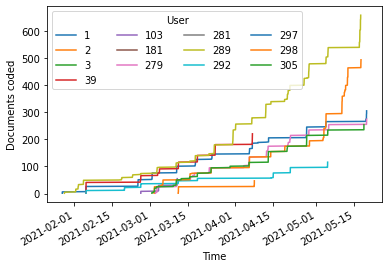

In [10]:
django.db.connection.close()
tags = Tag.objects.filter(query=tag.query)
df = pd.DataFrame.from_dict(DocOwnership.objects.filter(tag__in=tags).order_by('finish').values())
df['coded'] = np.where(df['relevant']>0,1,0)

fig, ax = plt.subplots()

for name, group in df.groupby('user_id'):
    group = group[~pd.isna(group['finish'])].sort_values('finish').set_index('finish')
    group['cumsum'] = group['coded'].cumsum()
    group['cumsum'].plot(label=name)
    #ax.plot(group.sort_values('finish')['finish'], group.sort_values('finish')['coded'].cumsum())

df.head()

l = ax.legend(ncol=4)
l.set_title('User')
ax.set_xlabel('Time')
ax.set_ylabel('Documents coded')
df.head()

Text(0, 0.5, 'Documents coded')

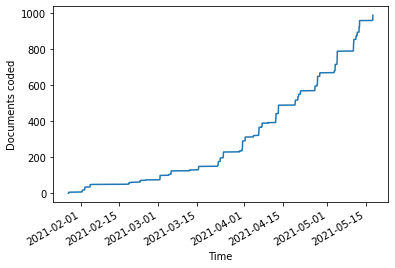

In [15]:
nd = df[~df.duplicated('doc_id')].sort_values('finish').set_index('finish')
fig, ax = plt.subplots()
nd['cumsum'] = nd['coded'].cumsum()
nd['cumsum'].plot()

ax.set_xlabel('Time')
ax.set_ylabel('Documents coded')

In [12]:
df.head()

,id,doc_id,docpar_id,utterance_id,tweet_id,document_linked,utterance_linked,title_only,full_text,project_id,user_id,query_id,tag_id,order,relevant,date,start,finish,coded
0,1630937,2647339,None,None,None,True,False,False,False,None,1,8843,5937,NaN,3,2021-01-26 13:49:20.134805+00:00,None,2021-01-27 16:00:09.098452+00:00,1
1,1630944,643753,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:22.183363+00:00,None,2021-01-27 16:01:34.019005+00:00,1
2,1630951,273713,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:24.947117+00:00,None,2021-01-27 16:03:18.194592+00:00,1
3,1630958,444393,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:28.276706+00:00,None,2021-01-27 16:04:54.931507+00:00,1
4,1630965,1727089,None,None,None,True,False,False,False,None,1,8843,5937,NaN,3,2021-01-26 13:49:30.630256+00:00,None,2021-01-27 16:05:25.882416+00:00,1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'frequency')

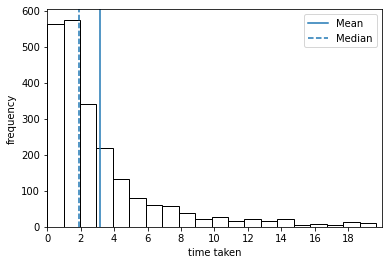

In [13]:
fig, ax = plt.subplots()

df['start'] = df['finish'].shift(1)
df['time'] = df['finish'] - df['start']
df['time'] = df['time'].astype('timedelta64[s]')
#maxtime = 600
maxtime = 1200
df.loc[df['time']>maxtime,'time'] = np.NaN
df.loc[df['time']<0,'time'] = np.NaN

ax.hist(df['time'],bins=20,fill=False)

ticksize = (60*2)
nticks = maxtime//ticksize
minticks, minticklabels = zip(*[(i*ticksize,i*2) for i in range(nticks)])

values = df.sort_values('time').loc[pd.notna(df['time']),'time']

mean = np.mean(values)

median = np.median(values)

ax.axvline(mean, label="Mean")

ax.axvline(median, ls="--", label="Median")

ax.legend()

ax.set_xticks(minticks)
ax.set_xticklabels(minticklabels)
ax.set_xlim(0,maxtime)

ax.set_xlabel('time taken')

ax.set_ylabel('frequency')

No handles with labels found to put in legend.


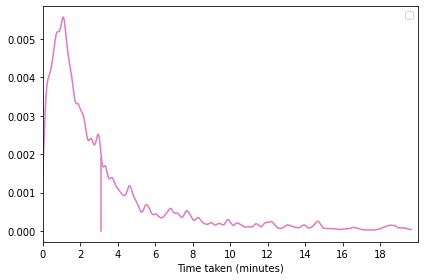

In [14]:


fig, ax = plt.subplots()

group = df

ticksize = (60*2)
nticks = maxtime//ticksize
minticks, minticklabels = zip(*[(i*ticksize,i*2) for i in range(nticks)])

values = group.sort_values('time').loc[pd.notna(group['time']),'time']
kernel = st.gaussian_kde(values, bw_method=0.03)
ax.plot(
    kernel.dataset.ravel(),
    kernel.pdf(kernel.dataset),
    #label=f"{name} (| mean)",
    color=f"C{i}"
)
mean = np.mean(values)
ax.plot(
    [mean,mean],
    [0,kernel.pdf(mean)],
    color=f"C{i}"
)

ax.set_xticks(minticks)
ax.set_xticklabels(minticklabels)
ax.set_xlim(0,maxtime)

ax.set_xlabel('Time taken (minutes)')

ax.legend()

fig.tight_layout()